In [8]:
import numpy as np
from scipy.stats import norm

from typing import Union, Tuple

import matplotlib.pyplot as plt

In [14]:
def geometric_brownian_motion(n_paths: int, n_periods: int,
                              drift: float, volatility: float, init_price: float, dt: float) -> np.ndarray:

    z = np.random.standard_normal((n_periods+1, n_paths)).cumsum(axis=0)
    z[0, :] = init_price

    noise_term = volatility * np.sqrt(dt) * z
    t = np.arange(0, (n_periods+1)*dt, dt).reshape(-1, 1) * dt

    return np.exp((drift - 0.5 * volatility ** 2) * t + noise_term)

def brownian_sim(num_path, num_period, mu, std, init_p, dt):
    z = np.random.normal(size=(num_period, num_path))

    a_price = np.zeros_like(z)
    a_price[0, :] = init_p

    for t in range(num_period - 1):
        a_price[t+1, :] = a_price[t, :] * np.exp(
            (mu - (std ** 2) / 2) * dt + std * np.sqrt(dt) * z[t, :]
        )
    return a_price

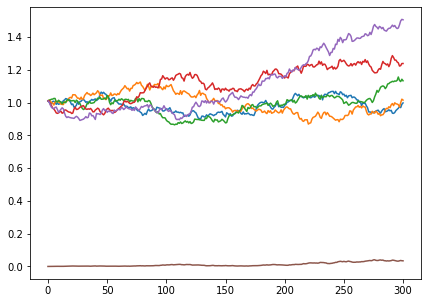

In [16]:
np.random.seed(42)

gbm = geometric_brownian_motion(5, 300, 0, 0.2, 1.0, 1/365)

plt.figure(figsize=(7,5))
for i in range(5):
    plt.plot(gbm[:, i])

plt.plot(np.var(gbm, axis=1))

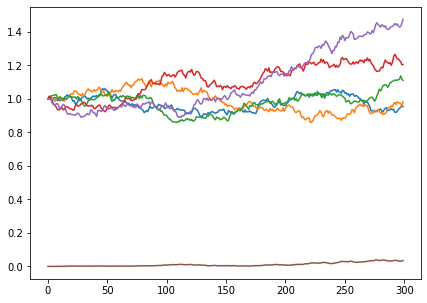

In [18]:
np.random.seed(42)

bs = brownian_sim(5, 300, 0, 0.2, 1.0, 1/365)

plt.figure(figsize=(7,5))
for i in range(5):
    plt.plot(bs[:, i])

plt.plot(np.var(bs, axis=1))

In [ ]:
def european_option_d1(moneyness: np.ndarray,
                       expiry: np.ndarray,
                       volatility: float,
                       risk_free_interest: float=0.0) -> np.ndarray:
    """
    Black-Scholes Model d1
    :param moneyness:
    :param expiry: T * dt
    :param volatility:
    :param risk_free_interest:
    """

    a = np.log(moneyness) + (risk_free_interest * 0.5 * volatility ** 2) * expiry
    b = volatility * np.sqrt(expiry)
    return a / b


def european_option_d2(moneyness: np.ndarray,
                       expiry: np.ndarray,
                       volatility: float,
                       risk_free_interest: float=0.0) -> np.ndarray:

    return european_option_d1(moneyness, expiry, volatility, risk_free_interest) - volatility * np.sqrt(expiry)


def european_call_price(moneyness: np.ndarray,
                        expiry: np.ndarray,
                        volatility: float,
                        risk_free_interest: float = 0.0,
                        strike: float = 1.0, dividend: float = 0.0,
                        delta_return: bool = False) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:

    normal = norm(loc=0.0, scale=1.0)
    d1 = european_option_d1(moneyness, expiry, volatility, risk_free_interest)
    d2 = d1 - volatility * np.sqrt(expiry)

    delta = normal.cdf(d1) * np.exp(-dividend * expiry)
    price = moneyness * strike * delta - \
            strike * normal.cdf(d2) * np.exp(-risk_free_interest * expiry)

    return price, delta if delta_return else price


def european_call_delta(moneyness: np.ndarray,
                        expiry: np.ndarray,
                        volatility: float,
                        risk_free_interest: float = 0.0,
                        strike: float = 1.0, dividend: float = 0.0) -> np.ndarray:

    normal = norm(loc=0.0, scale=1.0)
    d1 = european_option_d1(moneyness, expiry, volatility, risk_free_interest)
    return normal.cdf(d1) * np.exp(-dividend * expiry)


def european_option_payoff(prices: np.ndarray, strike: float = 1.0) -> np.ndarray:
    return np.clip(prices[-1] - strike, 0.0, np.inf)


def lookback_option_payoff(prices: np.ndarray, strike: float = 1.0) -> np.ndarray:
    return np.clip(np.max(prices, axis=0) - strike, 0.0, np.inf)
